
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [ ]:
import os
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision

from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import alexnet
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
LR = 0.01            # The initial Learning Rate - https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

PRE_TRAINED = False
AUGMENTATION = True

**Define Data Preprocessing - Data Augmentation**

In [ ]:
# Define transforms for training phase, applied on both training and validation set
train_transform = transforms.Compose([transforms.Resize(256),   
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
])

# Define transforms for the evalutation phase on test set
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),   
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),             
])

TTA_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.FiveCrop(224),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),  
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(crop) for crop in crops])),  
                                                      
])
# The following transformations are applied only if AUGMENTATION = True
augment_transform = transforms.Compose([transforms.ToPILImage(),
                                      #transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),                                  
])

# Applied only on the validation set
validation_transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                   
])

**Prepare Dataset**

In [ ]:
# Mount drive
! rm -r '/content/Caltech101'

from google.colab import drive
drive.mount('/content/drive')

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'
  # !rm '/content/Caltech101/caltech_dataset.py'
  !cp '/content/drive/My Drive/Colab Notebooks/caltech_dataset.py' '/content/Caltech101'

**Loading Data**


In [ ]:
from Caltech101.caltech_dataset import Caltech

DATA_DIR = 'Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
TTA_dataset = Caltech(DATA_DIR, split='test', transform=TTA_transform)

# Be careful to not filter out entire classes from the sets!

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
stratified = list(sss.split(train_dataset.data['images'], train_dataset.data['labels_encoded']))
train_indexes = stratified[0][0]
val_indexes = stratified[0][1]

train_subdataset = Subset(train_dataset, train_indexes)
val_subdataset = Subset(train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_subdataset)))
print('Valid Dataset: {}'.format(len(val_subdataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Data exploration**

In [ ]:
# Demonstrating unbalancing of the classes within Caltech-101

frames = [train_dataset.data, test_dataset.data]
dataset = pd.concat(frames)
occurrences = np.array(dataset.labels.value_counts())
occurrences.mean(), occurrences.std() 

(85.91089108910892, 117.75054173719958)

In [ ]:
# Ensuring balancing of classes in TRAIN / VAL sets

train_classes = []
for i in range(len(train_subdataset)):
  train_classes.append(train_subdataset[i][1])
trainClassesDf = pd.DataFrame(train_classes, columns=["label"])
trainVC = trainClassesDf["label"].value_counts()

val_classes = []
for i in range(len(val_subdataset)):
  val_classes.append(val_subdataset[i][1])
valClassesDf = pd.DataFrame(val_classes, columns=["label"])
valVC = valClassesDf["label"].value_counts()


differences = []
for train,val in zip(trainVC, valVC):
  differences.append(abs(train - val))

max(differences), len(set(list(trainClassesDf.label))), len(set(list(valClassesDf.label)))

(1, 101, 101)

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)

train_dataloader = DataLoader(train_subdataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_subdataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
TTA_dataloader = DataLoader(TTA_dataset, batch_size=64, shuffle=True, num_workers=4)

**Inspecting effects of data augmentation**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


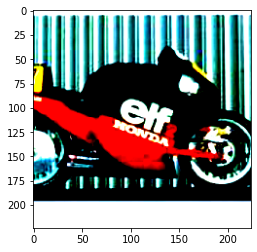

In [ ]:
transform = transforms.Compose([  transforms.Resize(256),
                                  transforms.RandomCrop(224), 
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

no_transform = transforms.Compose([ transforms.ToTensor(),])

train_with_trasform = Caltech(DATA_DIR, split='train',  transform=transform)
train_without_trasform = Caltech(DATA_DIR, split='train',  transform=no_transform)
trainsub_without_trasform = Subset(train_without_trasform, train_indexes)
trainsub_with_trasform = Subset(train_with_trasform, train_indexes)

no_augm_dataloader = DataLoader(trainsub_without_trasform, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)
augm_dataloader = DataLoader(trainsub_with_trasform, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

image_to_vis1 = no_augm_dataloader.dataset[5][0]
image_to_vis2 = augm_dataloader.dataset[5][0]
plt.imshow(image_to_vis2.permute(1, 2, 0))


**Prepare Network**

In [ ]:
from torchvision.models import resnet18

# net = alexnet(pretrained=PRE_TRAINED)
# net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

net = resnet18(pretrained=PRE_TRAINED)
net.fc = nn.Linear(512, NUM_CLASSES)

**Prepare Training**

In [ ]:
criterion = nn.CrossEntropyLoss() 

if (PRE_TRAINED == True):
  parameters_to_optimize = net.fc.parameters() 
else: parameters_to_optimize = net.parameters() 

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
def augment(images, transform):
  if(AUGMENTATION == True):
    tensors = []
    for img in images:
      tensors.append(transform(img))
    augmented_images = torch.stack(tensors)
    return augmented_images 
  else: return images

**Validation function**

In [ ]:
# Validation to be done after each epoch

def validation(val_dataloader, net):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  
  for images, labels in tqdm(val_dataloader):
    
    images = augment(images, validation_transform)

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    valLoss = criterion(outputs, labels)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_subdataset))
  print('Validation Accuracy: {}'.format(accuracy))

  return accuracy, valLoss.item()

**Train and evaluate the model after each epoch**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
accuracyScoresOnVal = []
accuracyScoresOnTrainSet = []
epochLosses = []
stepLosses = []
valLosses = []
trainLosses = []

start = time.time()

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {} LAST_LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    
    images = augment(images, augment_transform)

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    #stepLosses.append(loss.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients
    
    current_step += 1
 
  # At the end of each epoch I save accuracy score, loss and LR
  
  accuracyScoreVal, lossVal = validation(val_dataloader, net)
  accuracyScoreTrain, lossTrain = validation(train_dataloader, net)
  accuracyScoresOnTrainSet.append(accuracyScoreTrain)
  accuracyScoresOnVal.append(accuracyScoreVal)
  valLosses.append(lossVal)
  trainLosses.append(lossTrain)
  epochLosses.append(loss.item())
  
  

  # Step the scheduler
  scheduler.step()

end = time.time()
execution_time = end - start
print(f"Training execution time: {execution_time}s")

final_accuracy_val = validation(val_dataloader, net)
final_accuracy_train = validation(train_dataloader, net)

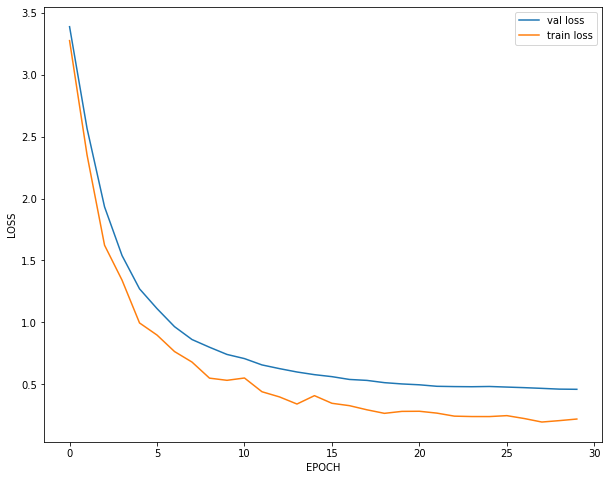

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,figsize=(10,8))
x = range(NUM_EPOCHS) 
ax.plot(valLosses, label = "val loss")
ax.plot(trainLosses, label = "train loss")
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('')
plt.legend()
plt.show()

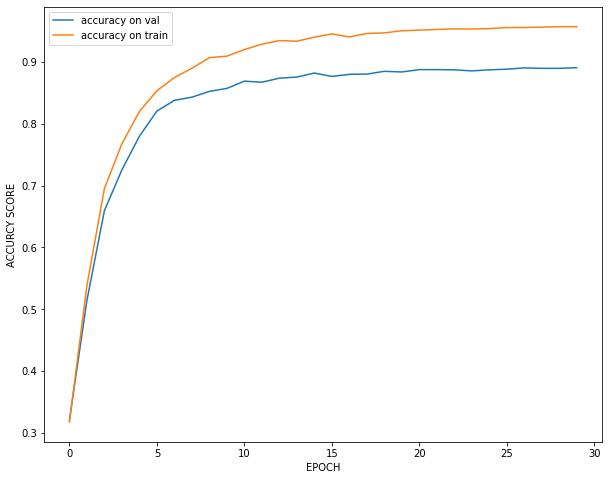

In [ ]:
f, ax = plt.subplots(1,figsize=(10,8))
x = range(NUM_EPOCHS) 
ax.plot(x, accuracyScoresOnVal, label = "accuracy on val")
ax.plot(x, accuracyScoresOnTrainSet, label = "accuracy on train")


plt.xlabel('EPOCH')
plt.ylabel('ACCURCY SCORE')
plt.title('')
plt.legend()
plt.show()

In [ ]:
# Saving results on result.txt
# ! rm -r 'drive/My Drive/results.txt'

results = f"LR={LR} | NUM_EPOCHS={NUM_EPOCHS} | GAMMA={GAMMA} | STEP_SIZE={STEP_SIZE} | BATCH_SIZE={BATCH_SIZE} | PRE_TRAINED={PRE_TRAINED} | AUGMENTATION={AUGMENTATION} | FINAL_LOSS={final_loss} | FINAL_ACCURACY_VAL={final_accuracy_val} | FINAL_ACCURACY_TRAIN={final_accuracy_train}\n"
f = open("drive/My Drive/results.txt",'a')
f.write(results)
f.close()

**Test**

In [ ]:
# Use only the best performing model on the validation set for testing
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  
  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()
# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

**Test after TTA**


In [ ]:
# Use only the best performing model on the validation set for testing
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(TTA_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Test-time data augmentation images, target = batch # input is a 5d tensor, target is 2d
  bs, ncrops, c, h, w = images.size()
  print(bs, ncrops, c, h, w )
  result = net(images.view(-1, c, h, w)) # fuse batch size and ncrops
  outputs = result.view(bs, ncrops, -1).mean(1)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()
# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))